# Secondary Label Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import ast
import os
import networkx as nx
from collections import Counter

In [2]:
# set up paths
DATA_DIR = Path('../data/raw')
TRAIN_CSV = DATA_DIR / 'train.csv'
TAXONOMY_CSV = DATA_DIR / 'taxonomy.csv'

In [3]:
# load data
train_df = pd.read_csv(TRAIN_CSV)
taxonomy_df = pd.read_csv(TAXONOMY_CSV)

In [4]:
# convert string representation of lists to actual lists
train_df['secondary_labels'] = train_df['secondary_labels'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)

In [5]:
# count recordings with secondary labels
has_secondary = train_df['secondary_labels'].apply(lambda x: x != [''])
print(f"Recordings with secondary labels: {has_secondary.sum()} ({has_secondary.mean()*100:.2f}%)")

Recordings with secondary labels: 2679 (9.38%)


In [6]:
# create a new column with the count of secondary labels
train_df['secondary_count'] = train_df['secondary_labels'].apply(
    lambda x: 0 if x == [''] else len(x)
)

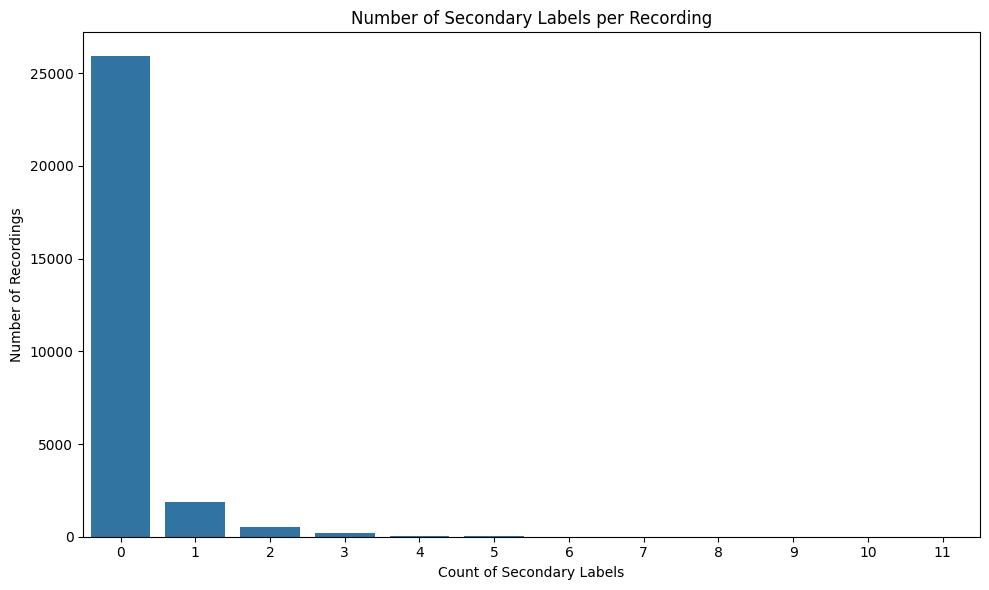

In [7]:
# distribution of secondary label counts
plt.figure(figsize=(10, 6))
sns.countplot(data=train_df, x='secondary_count')
plt.title('Number of Secondary Labels per Recording')
plt.xlabel('Count of Secondary Labels')
plt.ylabel('Number of Recordings')
plt.tight_layout()
plt.show()

In [8]:
# join with taxonomy for primary labels
train_with_taxonomy = pd.merge(
    train_df,
    taxonomy_df[['primary_label', 'class_name']],
    on = 'primary_label',
    how = 'left'
)

train_with_taxonomy = train_with_taxonomy.rename(columns={'class_name': 'primary_class'})

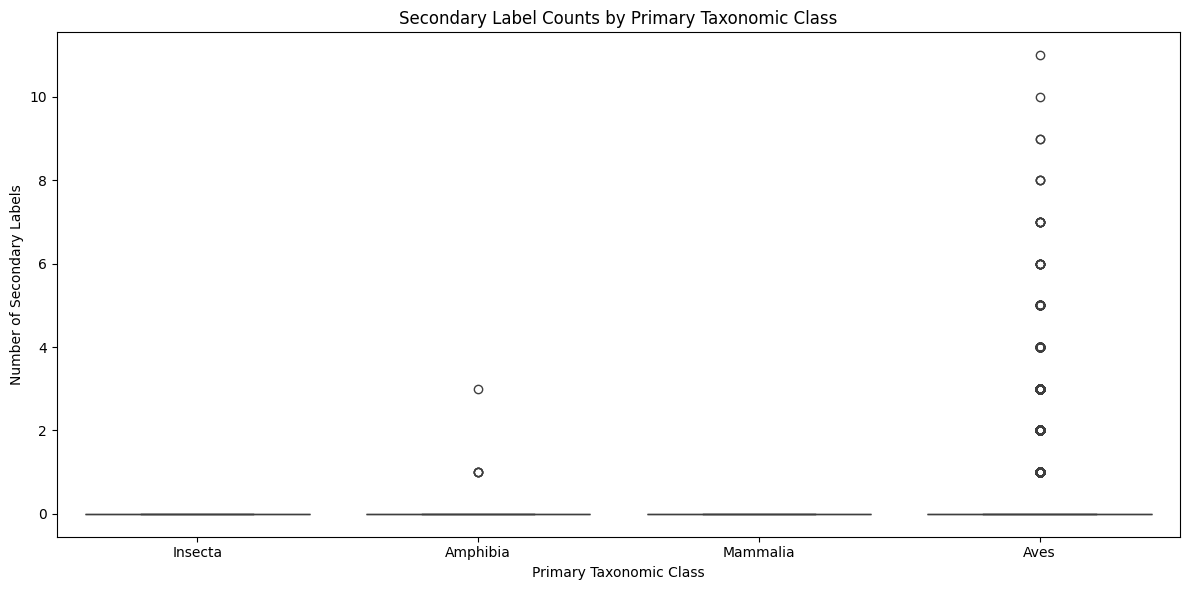

In [9]:
# analyze secondary label distribution by taxonomic class
plt.figure(figsize=(12, 6))
sns.boxplot(x='primary_class', y='secondary_count', data=train_with_taxonomy)
plt.title('Secondary Label Counts by Primary Taxonomic Class')
plt.xlabel('Primary Taxonomic Class')
plt.ylabel('Number of Secondary Labels')
plt.tight_layout()
plt.show()

In [10]:
# extract all secondary labels into a flat list
all_secondary_labels = []
for labels in train_df['secondary_labels']:
    if labels != ['']:
        all_secondary_labels.extend(labels)

In [11]:
# count frequency of secondary labels
secondary_label_counts = Counter(all_secondary_labels)
print(f"Number of unique secondary labels: {len(secondary_label_counts)}")

Number of unique secondary labels: 132


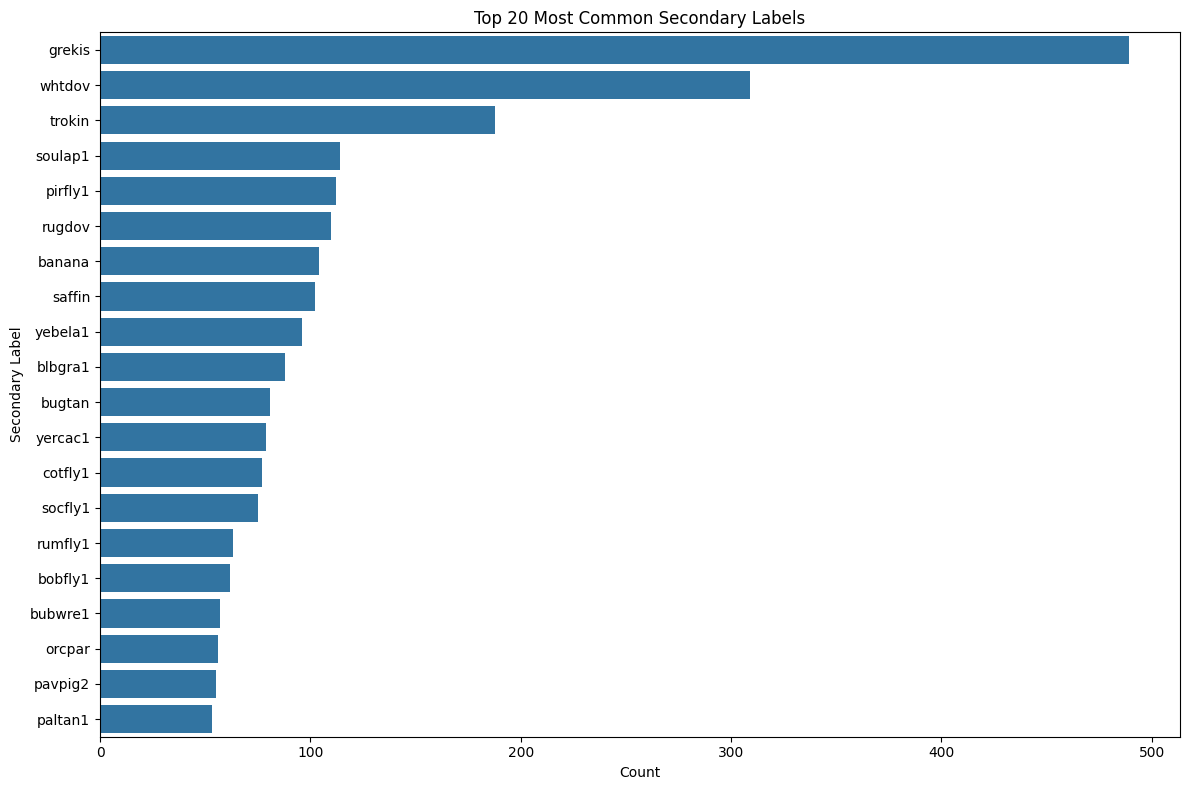

In [13]:
# top 20 most common secondary labels
top_secondary = pd.DataFrame(secondary_label_counts.most_common(20),
                             columns=['secondary_label', 'count'])

plt.figure(figsize=(12, 8))
sns.barplot(data=top_secondary, y='secondary_label', x='count')
plt.title('Top 20 Most Common Secondary Labels')
plt.xlabel('Count')
plt.ylabel('Secondary Label')
plt.tight_layout()
plt.show()

In [15]:
# create list of recordings with both primary and secondary labels
cooccurrence_data = []

for _, row in train_df.iterrows():
    if row['secondary_labels'] != ['']:
        primary = row['primary_label']
        for secondary in row['secondary_labels']:
            if secondary != '':
                cooccurrence_data.append((primary, secondary))

# count co-occurrences
cooccurrence_counts = Counter(cooccurrence_data)

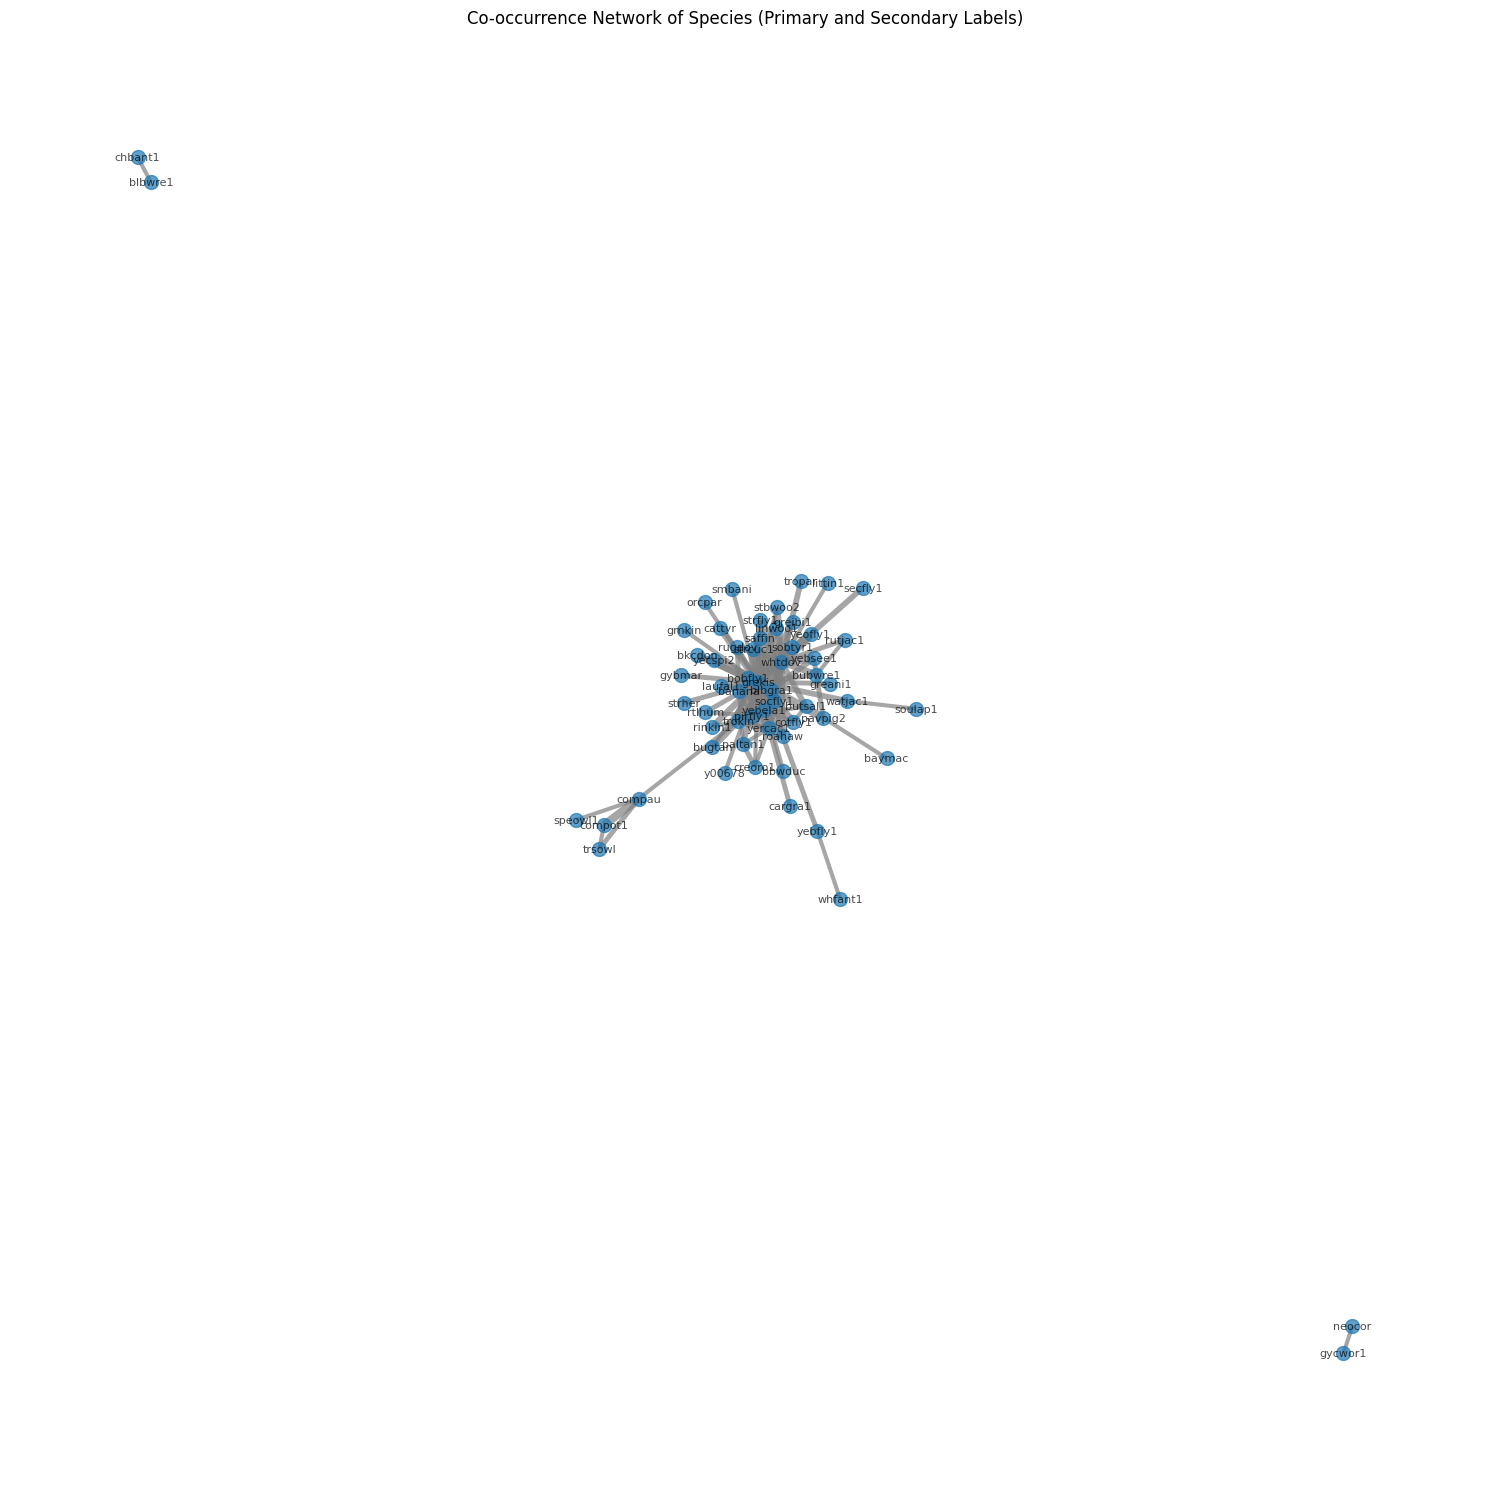

In [16]:
# create a co-occurrence network for visualization
G = nx.Graph()
for (primary, secondary), count in cooccurrence_counts.items():
    if count >= 5:
        G.add_edge(primary, secondary, weight=count)

# plot the network
plt.figure(figsize=(15, 15))
pos = nx.spring_layout(G, seed=42)
edge_weights = [G[u][v]['weight'] for u, v in G.edges()]

# normalize edge weights
max_weight = max(edge_weights)
edge_weights = [w/max_weight*10 for w in edge_weights]

nx.draw_networkx(
    G, pos,
    node_size = 100,
    font_size = 8,
    width = edge_weights,
    alpha = 0.7,
    edge_color = 'gray'
)
plt.title('Co-occurrence Network of Species (Primary and Secondary Labels)')
plt.axis('off')
plt.tight_layout()
plt.show()

In [17]:
# save co-occurrence data
cooccurrence_df = pd.DataFrame(cooccurrence_counts.items(), columns=['species_pair', 'count'])
cooccurrence_df[['primary_label', 'secondary_label']] = pd.DataFrame(
    cooccurrence_df['species_pair'].tolist(),
    index = cooccurrence_df.index
)
cooccurrence_df = cooccurrence_df.drop('species_pair', axis=1)

os.makedirs('../data/interim', exist_ok=True)
cooccurrence_df.to_csv('../data/interim/species_cooccurrence.csv', index=False)